In [1]:
import torch
import torchvision.models as model
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms,datasets
import os
import glob
from tqdm import tqdm
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import torch
import cv2

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
from tqdm import tqdm

In [2]:
Model = timm.create_model('resnet18', pretrained=True, num_classes=8)

In [3]:
class load_data(Dataset):
    def __init__(self, path):
        self.img_list = glob.glob(path)        

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_name = self.img_list[index]
        ret_img = cv2.imread(img_name)
        
        # 파일명에서 경로를 제외하고, 필요한 좌표 정보만 추출
        ret_coord = os.path.basename(img_name)  # 경로를 제외한 파일명만 가져옴
        ret_coord = ret_coord.split(".jpg")[0]  # 확장자 제거
        ret_coord = ret_coord.replace("__", "_")  # 구분자를 통일
        ret_coord = np.array(list(map(float, ret_coord.split("_"))))  # 좌표값을 float로 변환

        tp = random.randint(1,5) # related to shearing
        tp2 = random.randint(1,4) # related to brightness
        # shear transformation
        if tp==1:# shearing with y1
            ret_img, ret_coord = self.shear_y1(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        elif tp==2:# shearing with y2
            ret_img, ret_coord = self.shear_y2(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        elif tp==3:# shearing with x1
            ret_img, ret_coord = self.shear_x1(ret_img, ret_coord)
            #self.visualization(ret_img, ret_coord)
        elif tp==4:# shearing with x2
            ret_img, ret_coord = self.shear_x2(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        else:# no shaering
            ret_img, ret_coord = self.original(ret_img, ret_coord)
            #elf.visualization(ret_img, ret_coord)
        
        
        # 이미지가 None이 아닌지, 그리고 크기가 0이 아닌지 확인
        if ret_img is not None and ret_img.size != 0:
            ret_img = cv2.resize(ret_img, dsize=(128, 128))
        else:
            #print(f"Error: Image is empty or could not be loaded properly.")
            return None
        #plt.imshow(ret_img)
        #plt.show()

        if tp2 == 1: # no augmentation
            pass
        elif tp2 == 2: # whole brighten
            rnd_b = int(random.uniform(0, 50))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype = np.uint8)
            ret_img = cv2.add(ret_img, array)
        elif tp2 == 3: # whole darken
            rnd_b = int(random.uniform(0, 60))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype = np.uint8)
            ret_img = cv2.subtract(ret_img, array)

        else: # horizontal shadow (always the upper the darker because of shadow)
            rnd_cover = int(random.uniform(54, 74))
            rnd_step = int(random.uniform(13, 50))
            rnd_tilt = int(random.randint(-1, 1))

            mask_cover = rnd_cover
            mask = np.zeros(ret_img.shape[0:2], dtype = np.uint8) # (128, 256)

            for col in range(mask.shape[1]):
                for row in range(mask.shape[0]):
                    if row <= mask_cover:
                        mask[row][col] = 255
                if (col + 1) % rnd_step == 0:
                    mask_cover = mask_cover + rnd_tilt
            rnd_b = int(random.uniform(0, 50))
            array = np.full(ret_img.shape, (rnd_b, rnd_b, rnd_b), dtype=np.uint8)
            shadowed = cv2.subtract(ret_img, array, mask = mask)
            for row in range(shadowed.shape[0]):
                for col in range(shadowed.shape[1]):
                    if shadowed[row][col][0] == 0:
                        shadowed[row][col] = ret_img[row][col]
            ret_img = shadowed
        ret_img = ret_img / 255.0
        ret_coord = np.array(ret_coord)
        ret_img = ret_img.transpose((2, 0, 1))
        
        return ret_img, ret_coord, tp
    ########################################################################################################
    def visualization(self, input_img, coord, color=(0, 0, 255)):
        h, w = input_img.shape[:2]
        coord_list = [(int(w * coord[0]), int(h * coord[1])),
                      (int(w * coord[2]), int(h * coord[3])),
                      (int(w * coord[4]), int(h * coord[5])),
                      (int(w * coord[6]), int(h * coord[7]))]
        return coord_list
    ########################################################################################################
    def shear_y1(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(0,0.5)
        degree = round(degree, 2)
        #image shearing
        affy =  np.array([[1, 0, 0],[degree, 1, 0]], dtype=np.float32)
        dsty = cv2.warpAffine(src, affy, (w, h+ int(w * degree)))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        r = np.dot(ret_coord, hw)
        nh, nw = dsty.shape[:2]
        r = [[r[0][0],r[0][1]+r[0][0]*degree], [r[1][0],r[1][1]+r[1][0]*degree], [r[2][0],r[2][1]+r[2][0]*degree], [r[3][0],r[3][1]+r[3][0]*degree]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dsty, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
    
        cropped_img = dsty[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
    
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
            
        return cropped_img, new_coord
    ########################################################################################################
    def shear_y2(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(-0.5,0)
        degree = round(degree, 2)
        # image shearing
        affy =  np.array([[1, 0, 0],[degree, 1, -degree*w]], dtype=np.float32)
        degree = -degree
        dsty = cv2.warpAffine(src, affy, (w, h+ int(w * degree)))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dsty.shape[:2]
        degree = -degree
        r = np.dot(ret_coord, hw)
        r = [[r[0][0],r[0][1]+r[0][0]*degree-degree*w], [r[1][0],r[1][1]+r[1][0]*degree-degree*w], [r[2][0],r[2][1]+r[2][0]*degree-degree*w], [r[3][0],r[3][1]+r[3][0]*degree-degree*w]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        #print(ret_coord2)
        coord = self.visualization(dsty, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
       # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dsty[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
            
        return cropped_img, new_coord
    ########################################################################################################
    def shear_x1(self, input_img, ret_coord):
        src = input_img
        h,w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(0,0.5)
        degree = round(degree, 2)
        # image shearing
        affx =  np.array([[1, degree, 0],[0, 1, 0]], dtype=np.float32)
        dstx = cv2.warpAffine(src, affx, (w+ int(h * degree), h))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dstx.shape[:2]
        r = np.dot(ret_coord, hw)
        r = [[r[0][0]+r[0][1]*degree,r[0][1]], [r[1][0]+r[1][1]*degree,r[1][1]], [r[2][0]+r[2][1]*degree,r[2][1]], [r[3][0]+r[3][1]*degree,r[3][1]]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dstx, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dstx[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
        return cropped_img, new_coord
    ########################################################################################################
    def shear_x2(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        # shear 주는 정도
        degree = random.uniform(-0.5,0)
        degree = round(degree, 2)
        # image shearing
        affx =  np.array([[1, degree, -degree*h],[0, 1, 0]], dtype=np.float32)
        degree = -degree
        dstx = cv2.warpAffine(src, affx, (w+ int(h * degree), h))
        # 좌표 shearing
        hw = np.array([[w, 0],[0,h]])
        ret_coord = np.reshape(ret_coord, (4,2))
        nh, nw = dstx.shape[:2]
        degree = -degree
        r = np.dot(ret_coord, hw)
        r = [[r[0][0]+r[0][1]*degree -degree*h,r[0][1]], [r[1][0]+r[1][1]*degree -degree*h,r[1][1]], [r[2][0]+r[2][1]*degree -degree*h,r[2][1]], [r[3][0]+r[3][1]*degree -degree*h,r[3][1]]]
        r = [[r[0][0]/nw,r[0][1]/nh], [r[1][0]/nw,r[1][1]/nh], [r[2][0]/nw,r[2][1]/nh], [r[3][0]/nw,r[3][1]/nh]]
        ret_coord2 = np.array([r[0][0],r[0][1],r[1][0],r[1][1],r[2][0],r[2][1],r[3][0],r[3][1]])
        coord = self.visualization(dstx, ret_coord2)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = nw*(random.uniform(0.01, 0.03))
        pad_xl = nw*(random.uniform(0.01, 0.03))
        pad_yu = nh*(random.uniform(0.005, 0.015))
        pad_yd = nh*(random.uniform(0.005, 0.015))
        cropped_img = dstx[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
            
        return cropped_img, new_coord
    ########################################################################################################
    def original(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        coord = self.visualization(src, ret_coord)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = w*(random.uniform(0.01, 0.03))
        pad_xl = w*(random.uniform(0.01, 0.03))
        pad_yu = h*(random.uniform(0.005, 0.015))
        pad_yd = h*(random.uniform(0.005, 0.015))
        cropped_img = src[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
            
        return cropped_img, new_coord

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def visualization(img: torch.Tensor, coord:torch.Tensor, color=(0, 255, 0)):
    input_img = np.array((img.cpu().detach().numpy().transpose((1, 2, 0)) * 255.0)).astype(np.uint8) # (128, 128, 3)
    coord = coord.cpu().detach().numpy() # (8,)


    coord_list = [(int(128 * coord[0]), int(128 * coord[1])),
                  (int(coord[2] * 128), int(128 * coord[3])),
                  (int(128 * coord[4]), int(128 * coord[5])),
                  (int(128 * coord[6]), int(128 * coord[7]))]

    image = cv2.cvtColor(np.array(input_img), cv2.COLOR_BGR2RGB)
    img = cv2.line(image, coord_list[0], coord_list[1], color=color)
    img = cv2.line(img, coord_list[1], coord_list[2], color=color)
    img = cv2.line(img, coord_list[2], coord_list[3], color=color)
    img = cv2.line(img, coord_list[3], coord_list[0], color=color)
    

    print("visualizing...")
    plt.imshow(img[:,:,::-1])
    plt.show()



In [5]:
class ValidationDataset(Dataset):
    def __init__(self, path):
        self.img_list = glob.glob(path)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_name = self.img_list[index]
        # 파일명에서 경로를 제외하고, 필요한 좌표 정보만 추출
        ret_coord = os.path.basename(img_name)  # 경로를 제외한 파일명만 가져옴
        ret_coord = ret_coord.split(".jpg")[0]  # 확장자 제거
        ret_coord = ret_coord.replace("__", "_")  # 구분자를 통일
        ret_coord = np.array(list(map(float, ret_coord.split("_"))))  # 좌표값을 float로 변환

        ret_img = cv2.imread(img_name)

        
        ret_img, ret_coord = self.original(ret_img, ret_coord)


        # 이미지가 None이 아닌지, 그리고 크기가 0이 아닌지 확인
        if ret_img is not None and ret_img.size != 0:
            ret_img = cv2.resize(ret_img, dsize=(128, 128)) / 255.0
        else:
            print(f"Error: Image is empty or could not be loaded properly.")
            return None

        ret_img = ret_img.transpose((2, 0, 1))
        ret_coord = np.array(ret_coord)
        # ret_label = img_name.split("__")
        return ret_img, ret_coord
    
    def original(self, input_img, ret_coord):
        src = input_img
        h, w = src.shape[:2]
        coord = self.visualization(src, ret_coord)
        coord_x = []
        coord_y = []
        for i in coord:
            coord_x.append(i[0])
            coord_y.append(i[1])
        min_x = min(coord_x);min_y = min(coord_y)
        max_x = max(coord_x);max_y = max(coord_y)
        # cropped image의 padding
        pad_xr = w*(random.uniform(0.01, 0.03))
        pad_xl = w*(random.uniform(0.01, 0.03))
        pad_yu = h*(random.uniform(0.005, 0.015))
        pad_yd = h*(random.uniform(0.005, 0.015))
        cropped_img = src[int(min_y-pad_yu): int(min_y-pad_yu + max_y-min_y+pad_yu+pad_yd), int(min_x-pad_xl): int(min_x-pad_xl + max_x-min_x+pad_xr+pad_xl)]
        coord_x = list(map(lambda x: x -int(min_x-pad_xl), coord_x))
        coord_y = list(map(lambda x: x- int(min_y-pad_yu), coord_y))
        new_coord = []
        h2, w2 = cropped_img.shape[:2]
        
        # w2 또는 h2가 0이면 1e-10으로 대체
        epsilon = 1e-10
        w2 = w2 if w2 != 0 else epsilon
        h2 = h2 if h2 != 0 else epsilon
        
        new_coord = []
        
        for i in range(4):
            new_coord.append(coord_x[i] / w2)
            new_coord.append(coord_y[i] / h2)
            
        return cropped_img, new_coord
    def visualization(self, input_img, coord, color=(0, 0, 255)):
        h, w = input_img.shape[:2]
        coord_list = [(int(w * coord[0]), int(h * coord[1])),
                      (int(w * coord[2]), int(h * coord[3])),
                      (int(w * coord[4]), int(h * coord[5])),
                      (int(w * coord[6]), int(h * coord[7]))]
        return coord_list

In [6]:
def collate_fn(batch):
    # None 값을 제거하고 유효한 데이터만 필터링
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

train_path = r".\data\train\newimage\*.jpg"
test_path =  r".\data\val\newimage\*.jpg"
train_dataset = load_data(train_path)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, collate_fn=collate_fn, pin_memory=True)
test_dataset = ValidationDataset(test_path)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [7]:
# L1Loss

epoch = 128
device = torch.device('cuda')
Model.cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.05, momentum=0.9, nesterov=True)
x = torch.randn(64, 3, 128, 128, requires_grad = True).cuda() #dummy input
best = 10000
count = 0


::::Train::::


 18%|███████████████                                                                    | 4/22 [00:03<00:16,  1.08it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:08<00:10,  1.17it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:14<00:05,  1.12it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:16<00:03,  1.06it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:19<00:00,  1.15it/s]


0.2106958364774456
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.08it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.72it/s]


smaller rmse, saving model weights...
best:  10000 current rmse:  0.09964194
epoch0 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


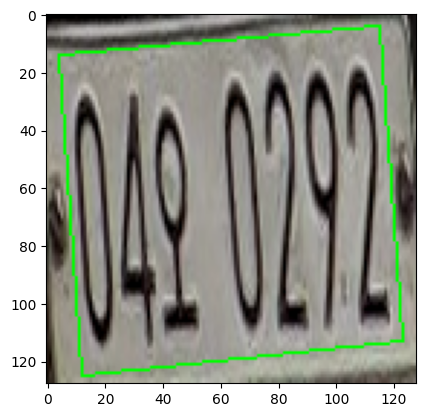

visualizing...


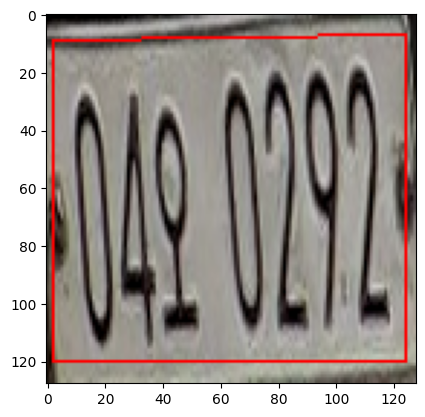

  9%|███████▌                                                                           | 2/22 [00:01<00:15,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:10,  1.38it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.31it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


0.3291375443251951
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

visualizing...


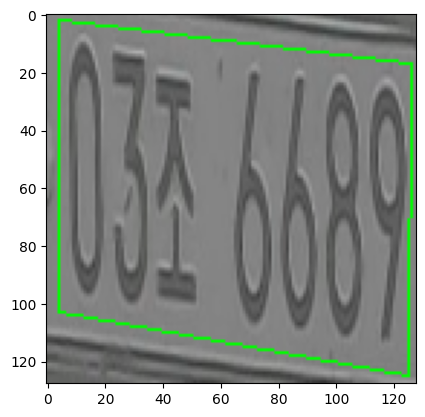

visualizing...


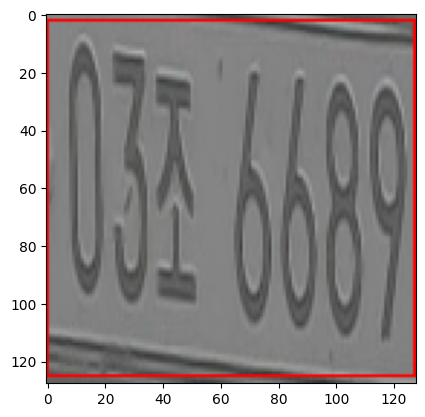

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


smaller rmse, saving model weights...
best:  0.09964194 current rmse:  0.09948138
epoch1 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


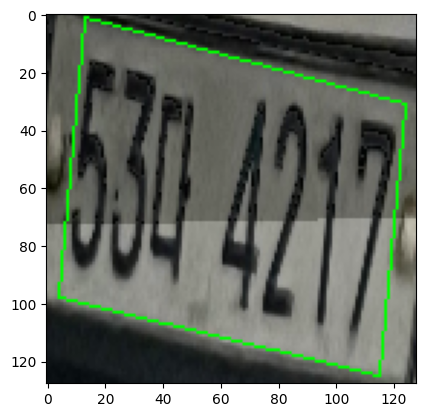

visualizing...


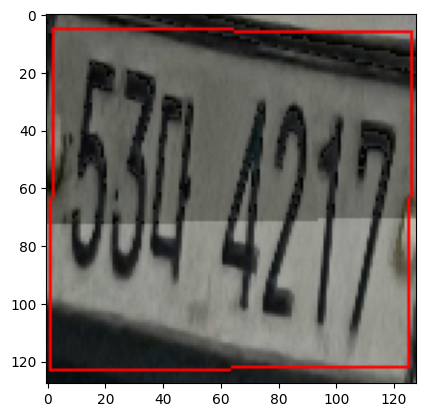

 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.40it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.31it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.36it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.42it/s]


0.4781010978684804
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.37it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.70it/s]


smaller rmse, saving model weights...
best:  0.09948138 current rmse:  0.096533
epoch2 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


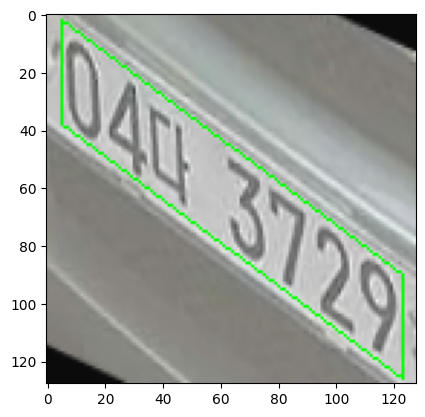

visualizing...


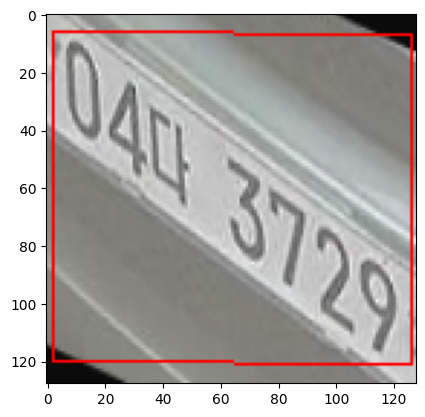

 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:03,  1.79it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.58it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.47it/s]


0.508763861888883
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.42it/s]


smaller rmse, saving model weights...
best:  0.096533 current rmse:  0.09404802
epoch3 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


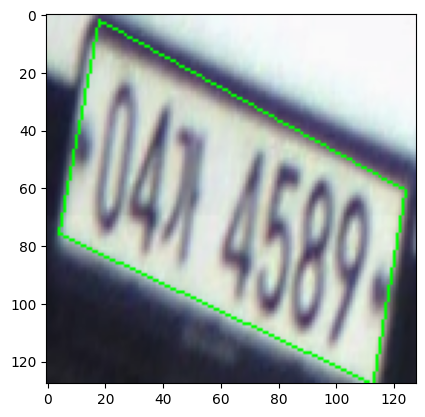

visualizing...


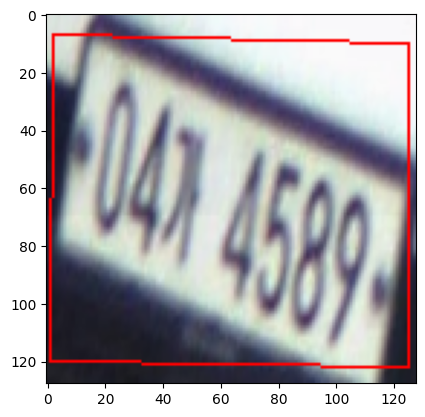

 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.45it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.48it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.42it/s]


0.3087714924302546
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.68it/s]


smaller rmse, saving model weights...
best:  0.09404802 current rmse:  0.09288944
epoch4 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


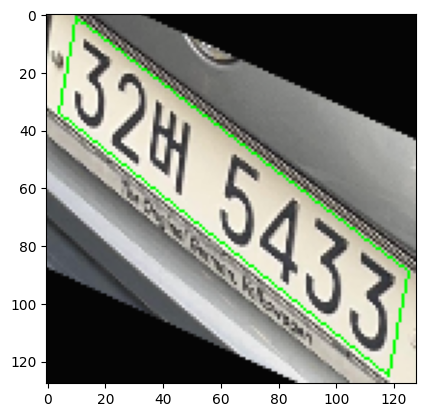

visualizing...


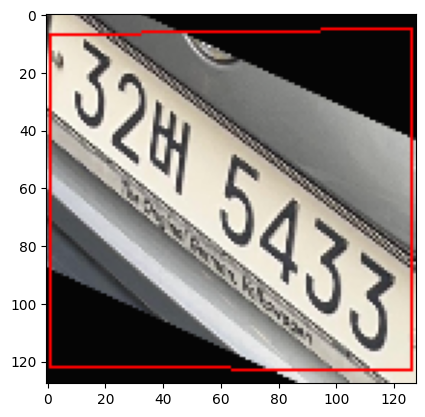

 14%|███████████▎                                                                       | 3/22 [00:02<00:14,  1.29it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.31it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:06,  1.28it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:15<00:00,  1.30it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:16<00:00,  1.37it/s]


0.1984635264196
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.89it/s]


smaller rmse, saving model weights...
best:  0.09288944 current rmse:  0.08893468
epoch5 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


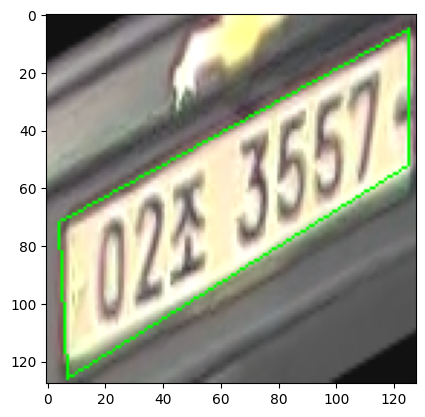

visualizing...


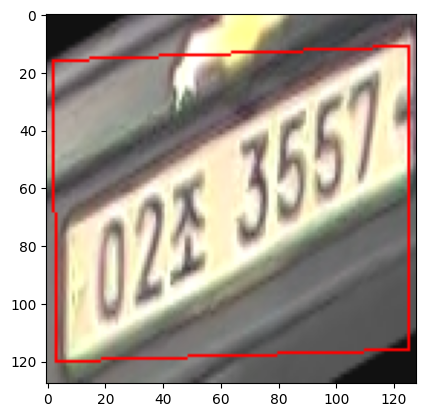

 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.65it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


0.1956972720270807
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.77it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.41it/s]

smaller rmse, saving model weights...
best:  0.08893468 current rmse:  0.08676167


epoch6 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


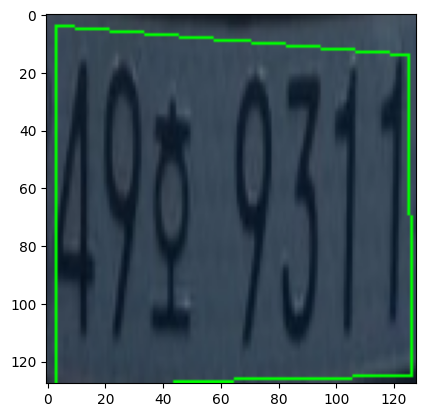

visualizing...


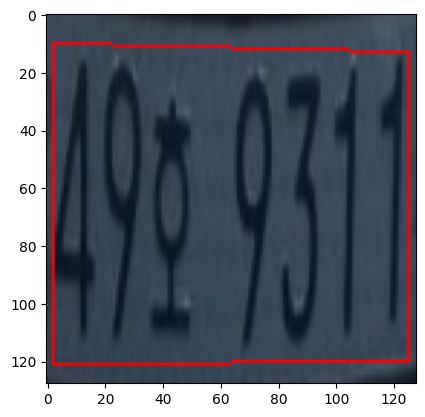

  5%|███▊                                                                               | 1/22 [00:00<00:15,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.34it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.06757513545015922
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.50it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.12it/s]

smaller rmse, saving model weights...
best:  0.08676167 current rmse:  0.082677886


epoch7 end
::::Train::::


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:10,  1.43it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:13<00:03,  1.26it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:14<00:02,  1.31it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.38it/s]


0.07404664713657383
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.34it/s]


smaller rmse, saving model weights...
best:  0.082677886 current rmse:  0.07362858
epoch8 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:16,  1.30it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:13,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.38it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.6248497844114079
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.02it/s]


smaller rmse, saving model weights...
best:  0.07362858 current rmse:  0.063773535
epoch9 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


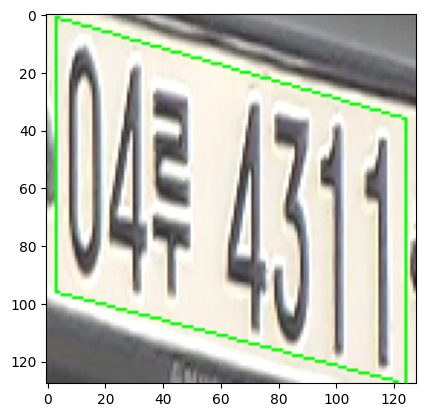

visualizing...


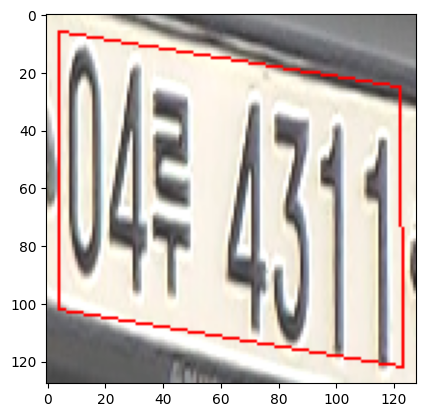

 18%|███████████████                                                                    | 4/22 [00:03<00:14,  1.21it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:08<00:08,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:10<00:06,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.39it/s]


0.0703575837720385
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

visualizing...


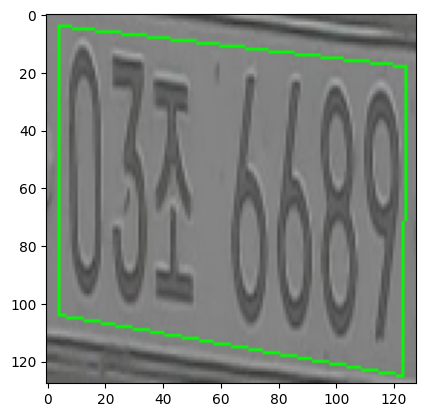

visualizing...


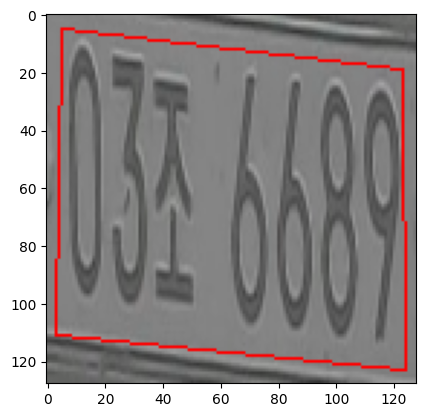

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


smaller rmse, saving model weights...
best:  0.063773535 current rmse:  0.057130825
epoch10 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.16it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:15,  1.25it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


0.24011591693544843
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.18it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.30it/s]


epoch11 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:15,  1.28it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:10,  1.30it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:03,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.05632318452873946
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.54it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.94it/s]


smaller rmse, saving model weights...
best:  0.057130825 current rmse:  0.05334989
epoch12 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:11,  1.72it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.53it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.06704673690537175
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.75it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.28it/s]


smaller rmse, saving model weights...
best:  0.05334989 current rmse:  0.05207189
epoch13 end
::::Train::::


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:07,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.0804791049329025
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.23it/s]


smaller rmse, saving model weights...
best:  0.05207189 current rmse:  0.050855655
epoch14 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.42it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.66it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.53it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.14846053641955873
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.66it/s]


smaller rmse, saving model weights...
best:  0.050855655 current rmse:  0.048852924
epoch15 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.46it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.20406714387380046
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.02it/s]


smaller rmse, saving model weights...
best:  0.048852924 current rmse:  0.04759194
epoch16 end
::::Train::::


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.68it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:04,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.57it/s]


Error: Image is empty or could not be loaded properly.
0.16837646448690927
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.32it/s]


epoch17 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.4653515733371237
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.50it/s]


epoch18 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:13,  1.52it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.57it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:04,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.34it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.57it/s]


0.08844462466917155
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.07it/s]


smaller rmse, saving model weights...
best:  0.04759194 current rmse:  0.046142858
epoch19 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


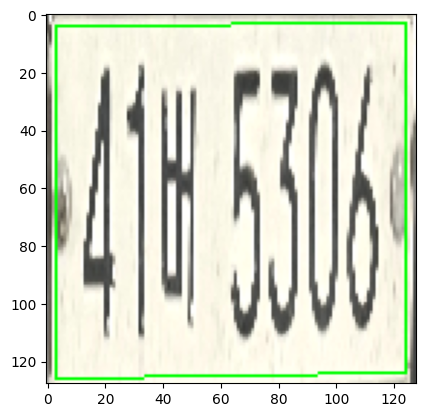

visualizing...


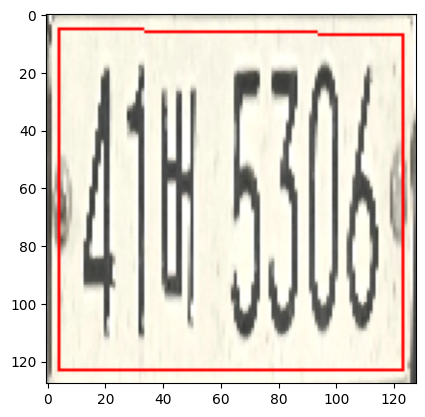

  5%|███▊                                                                               | 1/22 [00:01<00:24,  1.15s/it]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.48it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


0.17573911683143323
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


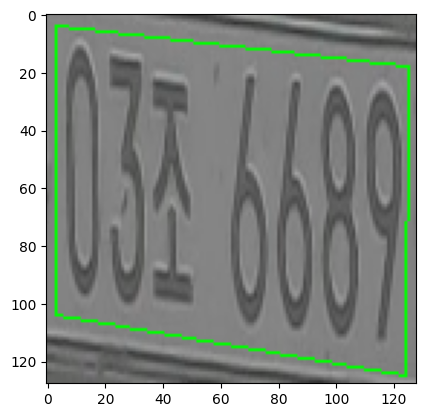

visualizing...


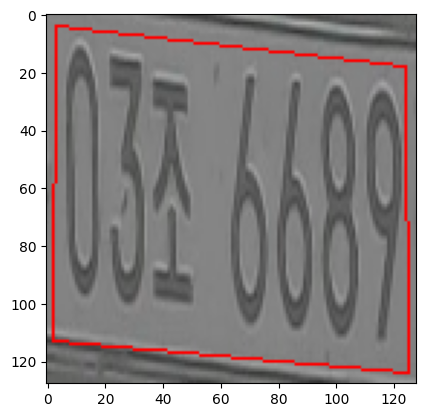

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


smaller rmse, saving model weights...
best:  0.046142858 current rmse:  0.04555755
epoch20 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  5%|███▊                                                                               | 1/22 [00:00<00:15,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:09,  1.76it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.42464078104182235
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.22it/s]


epoch21 end
::::Train::::


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.43it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:13<00:02,  1.38it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


0.1125530344065377
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.84it/s]


epoch22 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:14,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:08,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:07,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:06,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.47it/s]


0.11586238002036961
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.51it/s]


smaller rmse, saving model weights...
best:  0.04555755 current rmse:  0.04156079
epoch23 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.45it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.28it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.42it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.1618407971143001
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.76it/s]


epoch24 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:14,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.42it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.25it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.4472643080879982
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.53it/s]


smaller rmse, saving model weights...
best:  0.04156079 current rmse:  0.040565364
epoch25 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:11,  1.80it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:13,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.16697866152808113
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.88it/s]

Error: Image is empty or could not be loaded properly.
smaller rmse, saving model weights...
best:  0.040565364 current rmse:  0.037460897


epoch26 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.54it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.58it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


Error: Image is empty or could not be loaded properly.
0.23971630919248785
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.22it/s]


epoch27 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:08,  1.55it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.46it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.35847288763433455
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.19it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


epoch28 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.14517325396299013
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.00it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.97it/s]


smaller rmse, saving model weights...
best:  0.037460897 current rmse:  0.035801373
epoch29 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


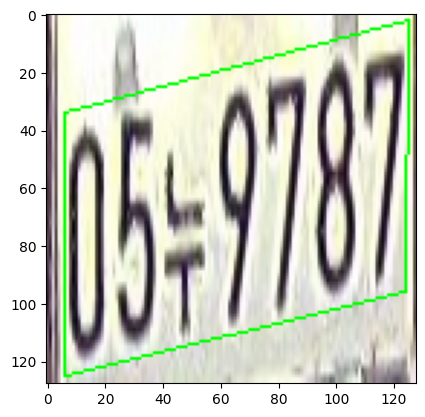

visualizing...


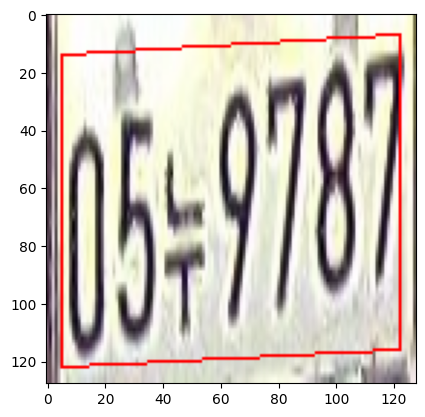

 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.68it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.63it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


0.2045460038344204
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


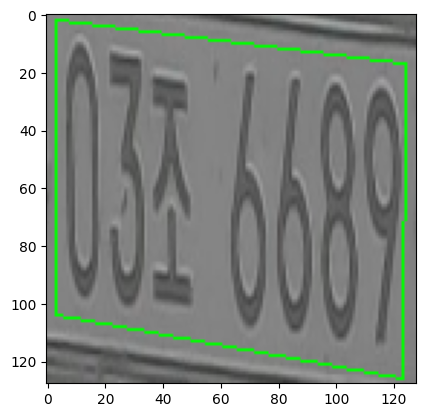

visualizing...


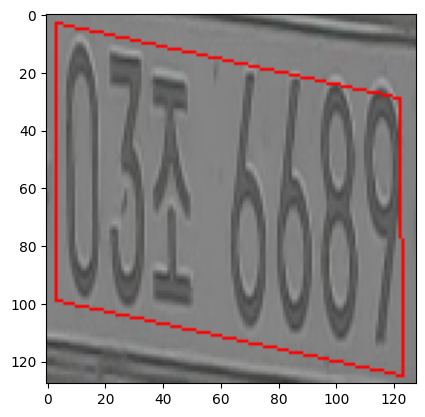

 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  3.06it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


smaller rmse, saving model weights...
best:  0.035801373 current rmse:  0.03467518
epoch30 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:12,  1.67it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:13,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.55it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.10642988472269549
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.02it/s]


epoch31 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.34it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.43it/s]


0.1616159313682453
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.46it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


smaller rmse, saving model weights...
best:  0.03467518 current rmse:  0.033604033
epoch32 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:13,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.41it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.16539872603998693
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.55it/s]

Error: Image is empty or could not be loaded properly.


smaller rmse, saving model weights...
best:  0.033604033 current rmse:  0.031744506
epoch33 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.36it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.44it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.4681248482783759
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.53it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.16it/s]


epoch34 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.0817833683123031
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.45it/s]


epoch35 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:13,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:06,  1.30it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.50it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.12223085043323705
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.08it/s]


epoch36 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.50it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.21244364463663293
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.72it/s]

Error: Image is empty or could not be loaded properly.


epoch37 end
::::Train::::


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.37it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.46it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.13448267622613225
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.15it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.87it/s]


epoch38 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.64it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:01<00:13,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:12<00:03,  1.38it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.47it/s]


0.056034586785811434
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.81it/s]


epoch39 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


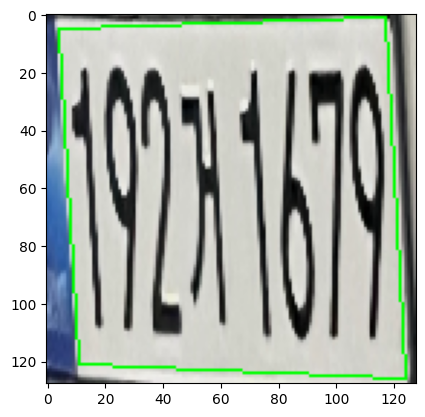

visualizing...


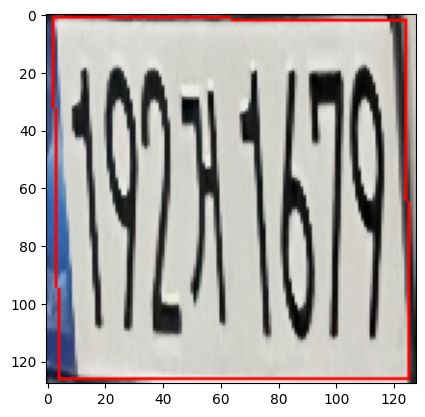

 18%|███████████████                                                                    | 4/22 [00:03<00:13,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.34it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:15<00:00,  1.42it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.42it/s]


0.13269277497092896
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


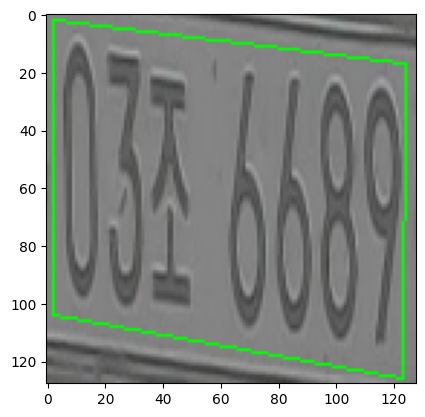

visualizing...


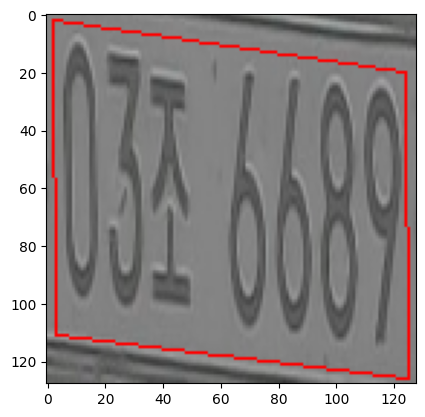

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


smaller rmse, saving model weights...
best:  0.031744506 current rmse:  0.031357747
epoch40 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:08,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.57it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.11026591660617731
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.78it/s]


epoch41 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:15,  1.27it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:05,  1.50it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.57it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.50it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.3758811807497031
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.18it/s]

Error: Image is empty or could not be loaded properly.


epoch42 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:10,  2.01it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:08,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


0.3393579939942905
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.72it/s]

Error: Image is empty or could not be loaded properly.


epoch43 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  5%|███▊                                                                               | 1/22 [00:00<00:16,  1.31it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.50it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.10612267813484165
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.52it/s]

Error: Image is empty or could not be loaded properly.


epoch44 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.43419445712009774
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.00it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.96it/s]


epoch45 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:14,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.30it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.34009840163937854
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.65it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.82it/s]


epoch46 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.27it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.16240557703998063
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.99it/s]

Error: Image is empty or could not be loaded properly.


epoch47 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:15,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.29it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.04411644995141649
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.64it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.55it/s]

smaller rmse, saving model weights...
best:  0.031357747 current rmse:  0.030968692


epoch48 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.31it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.08635028289587311
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.38it/s]


smaller rmse, saving model weights...
best:  0.030968692 current rmse:  0.030539377
epoch49 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


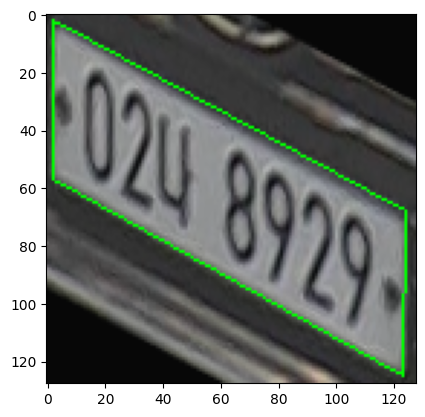

visualizing...


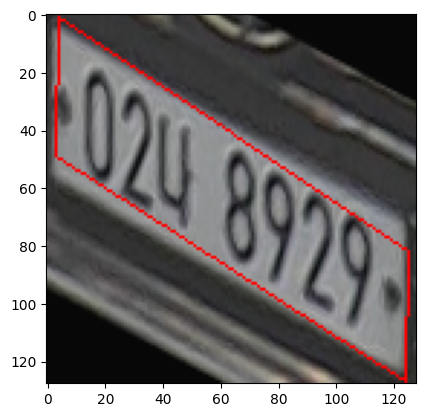

  5%|███▊                                                                               | 1/22 [00:00<00:20,  1.01it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:13,  1.30it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:07,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:05,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.1414481703465914
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

visualizing...


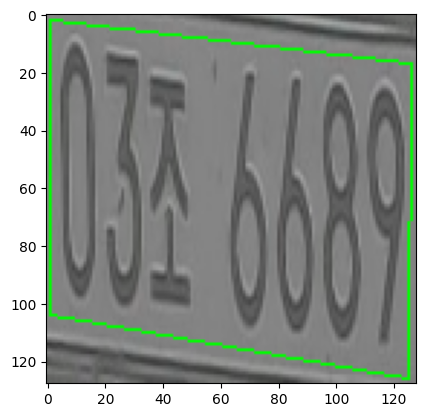

visualizing...


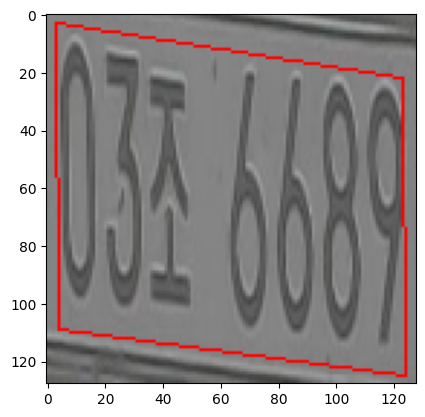

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.01it/s]


epoch50 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:11,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.57it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.51it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


0.10077406313770498
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.41it/s]

Error: Image is empty or could not be loaded properly.


epoch51 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.44it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.22197089258715325
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.21it/s]


epoch52 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  5%|███▊                                                                               | 1/22 [00:00<00:15,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:08<00:08,  1.27it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:11<00:05,  1.30it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.58it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.04579613380314362
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.95it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.73it/s]


epoch53 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.46it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.12759769529295273
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.50it/s]


epoch54 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:04,  1.65it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.50it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


0.4237291978610741
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.83it/s]

Error: Image is empty or could not be loaded properly.


epoch55 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:12,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.06383356759379293
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.93it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


epoch56 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:13,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.44it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


Error: Image is empty or could not be loaded properly.
0.042699365390796745
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.06it/s]


epoch57 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:13,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.64it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.021750112165992784
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.35it/s]

Error: Image is empty or could not be loaded properly.


smaller rmse, saving model weights...
best:  0.030539377 current rmse:  0.028686197
epoch58 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:12,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:10,  1.79it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.63it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.60it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.0923521604296025
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.26it/s]


epoch59 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:09,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.03578831853011836
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.33it/s]


epoch60 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:14,  1.42it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.65it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.46it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.03750252166814916
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.57it/s]


epoch61 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:16,  1.31it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.17863961831637148
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.85it/s]

Error: Image is empty or could not be loaded properly.


epoch62 end
::::Train::::


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.36it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.35it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


0.15309575470750755
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.69it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.16it/s]


epoch63 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.38it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.44it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


0.08702661000082598
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.75it/s]


epoch64 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.48it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


Error: Image is empty or could not be loaded properly.
0.051639418433149974
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.98it/s]


epoch65 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:09,  1.91it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.34it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.07475656373446757
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.95it/s]


smaller rmse, saving model weights...
best:  0.028686197 current rmse:  0.02853513
epoch66 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:08,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.2905964409383533
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 16.07it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.12it/s]


epoch67 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.46it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.61it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.66it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.62it/s]


0.020418688285652763
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.92it/s]

Error: Image is empty or could not be loaded properly.


smaller rmse, saving model weights...
best:  0.02853513 current rmse:  0.027262675
epoch68 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:10,  1.65it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:10<00:03,  1.59it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.07376207270701901
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.95it/s]


epoch69 end
::::Train::::


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:09<00:07,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.51it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.2842305694225725
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.81it/s]


epoch70 end
::::Train::::


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.16744853722088504
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.32it/s]

Error: Image is empty or could not be loaded properly.


epoch71 end
::::Train::::


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:07,  1.71it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:06<00:06,  1.75it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:08<00:04,  1.74it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:10<00:03,  1.62it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.60it/s]


0.13402107369586214
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.22it/s]

Error: Image is empty or could not be loaded properly.


epoch72 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.58it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.1587800103432544
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.79it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.60it/s]


epoch73 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:09,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.46it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.40315973090465035
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.65it/s]

Error: Image is empty or could not be loaded properly.


epoch74 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.48it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


Error: Image is empty or could not be loaded properly.
0.04149372218495603
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.95it/s]


smaller rmse, saving model weights...
best:  0.027262675 current rmse:  0.027183224
epoch75 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:04,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.69it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:13<00:00,  1.55it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.61it/s]


0.034004449588246645
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.32it/s]


epoch76 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.3268144718614404
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.13it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.12it/s]


epoch77 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:11,  1.68it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.51it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.111198910349288
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.58it/s]

Error: Image is empty or could not be loaded properly.


epoch78 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.56it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.27it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.40it/s]


0.058352630466365095
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.71it/s]


epoch79 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

visualizing...


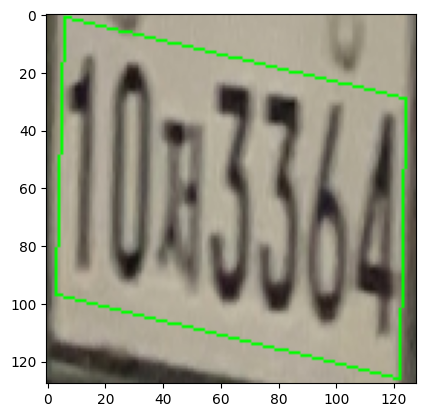

visualizing...


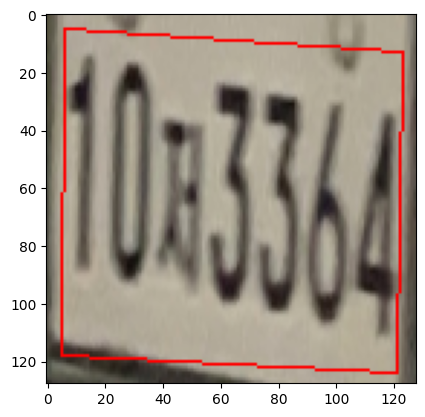

  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.51it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.33it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.43358552912960263
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

visualizing...


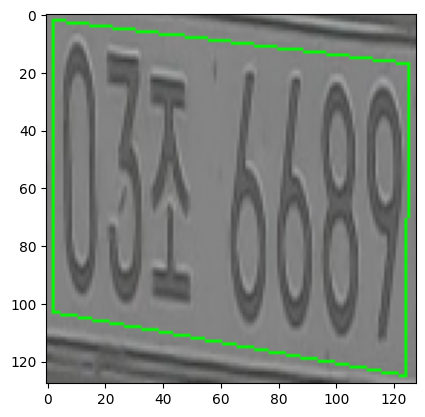

visualizing...


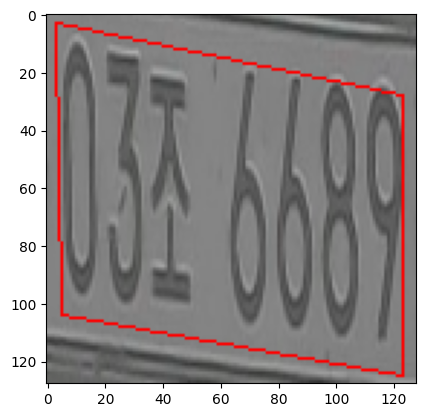

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch80 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:15,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.42it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.43it/s]


0.2455048591371003
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.75it/s]


epoch81 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:12,  1.66it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.44it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.66it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.06166649613502052
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.40it/s]


epoch82 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.64it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:11,  1.56it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:04,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.15072026121376764
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.65it/s]


epoch83 end
::::Train::::


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.67it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.54it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.0832325877178283
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.58it/s]

Error: Image is empty or could not be loaded properly.


epoch84 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:10,  1.88it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:09,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.42it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.13299336184292113
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.47it/s]

Error: Image is empty or could not be loaded properly.


epoch85 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.43it/s]


0.04031900244396406
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.00it/s]

Error: Image is empty or could not be loaded properly.


epoch86 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:04<00:08,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:06<00:07,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.61it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.63it/s]


0.3419498752761673
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.58it/s]


smaller rmse, saving model weights...
best:  0.027183224 current rmse:  0.026950093
epoch87 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  5%|███▊                                                                               | 1/22 [00:00<00:14,  1.49it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:12,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.41it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.43it/s]


0.25488029080692853
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 16.00it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.01it/s]


epoch88 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:07,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.40it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.2230044931709023
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.71it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.62it/s]


epoch89 end
::::Train::::


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.36it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:03,  1.61it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.48it/s]


0.08232788723276453
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.89it/s]


epoch90 end
::::Train::::


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.11441518529147826
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.41it/s]


epoch91 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:17,  1.23it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.37it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.07311445857000246
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.26it/s]


epoch92 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.62it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.47it/s]


0.2850943887108193
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.39it/s]


epoch93 end
::::Train::::


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.55it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.2822301160880335
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.08it/s]


epoch94 end
::::Train::::


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.55it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.18968157640388816
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.16it/s]


epoch95 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:13,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.54it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


0.27114469796643426
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.79it/s]


epoch96 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:03<00:14,  1.26it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:13,  1.26it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.63it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


0.09188003350194114
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.91it/s]


epoch97 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:17,  1.20it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:06,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.56it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.71it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.032697405160107974
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.59it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.76it/s]


epoch98 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.42it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:07,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.64it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:05,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.3209340809782893
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.89it/s]

Error: Image is empty or could not be loaded properly.


epoch99 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
visualizing...


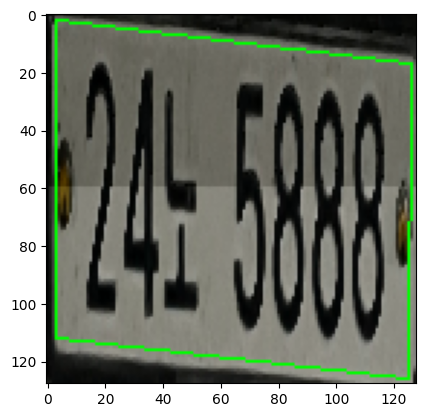

visualizing...


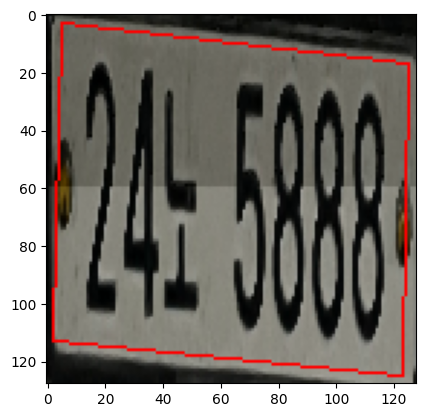

 18%|███████████████                                                                    | 4/22 [00:03<00:13,  1.29it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:08<00:07,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.59it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.51it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.26736683470457245
::::Validation::::


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

visualizing...


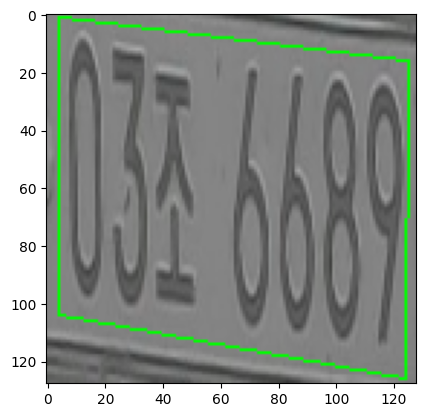

visualizing...


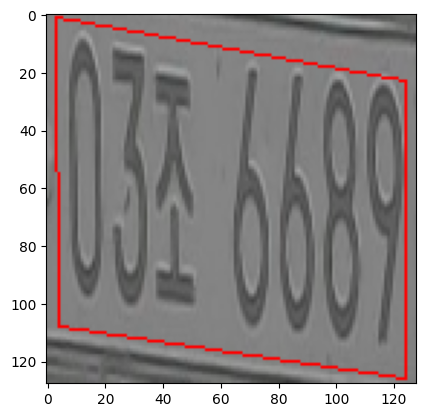

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch100 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:08,  1.73it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.44it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


0.42847090179207303
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.77it/s]


epoch101 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:14,  1.34it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.52it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


0.12122683765781808
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.24it/s]

Error: Image is empty or could not be loaded properly.


epoch102 end
::::Train::::


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.47it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.0648425399512598
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.22it/s]


epoch103 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:13,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:10,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.37it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.53it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:11<00:04,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:14<00:01,  1.39it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.44it/s]


0.15356433612948753
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.91it/s]


epoch104 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:13,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:07,  1.42it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.05020059580720764
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.48it/s]


smaller rmse, saving model weights...
best:  0.026950093 current rmse:  0.026779853
epoch105 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:13,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:02<00:10,  1.65it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:09,  1.51it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.06842729692754289
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.38it/s]


epoch106 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.38it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.41it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.56it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.34it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.49it/s]


Error: Image is empty or could not be loaded properly.
0.017979191290214656
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.55it/s]


epoch107 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:13,  1.55it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.50it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:04,  1.55it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.57it/s]


0.05747552595156081
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.99it/s]


epoch108 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:09,  1.35it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:08,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:07,  1.36it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.13363455654574605
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.58it/s]


epoch109 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:11,  1.89it/s]

Error: Image is empty or could not be loaded properly.


 18%|███████████████                                                                    | 4/22 [00:03<00:14,  1.28it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.35it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.34it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.48it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:11<00:05,  1.35it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.40it/s]


0.050275478316340966
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.18it/s]

Error: Image is empty or could not be loaded properly.


epoch110 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:12,  1.69it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:01<00:12,  1.53it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:08,  1.59it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.06468214595489483
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.61it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.36it/s]


epoch111 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:11,  1.70it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.58it/s]


0.32249805820021
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.36it/s]


smaller rmse, saving model weights...
best:  0.026779853 current rmse:  0.026346788
epoch112 end
::::Train::::


 18%|███████████████                                                                    | 4/22 [00:02<00:12,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:08,  1.57it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:06,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.43it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.39it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.12977308871787965
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.15it/s]

Error: Image is empty or could not be loaded properly.


epoch113 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.69it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:10,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.32it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:08<00:06,  1.62it/s]

Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.60it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.68it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.57it/s]


0.04260350393591912
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 16.71it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.38it/s]


epoch114 end
::::Train::::


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.73it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.41it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.55it/s]


0.09247640175710777
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.63it/s]


epoch115 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:02<00:13,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.44it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.45it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


0.018343554221126428
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.05it/s]


epoch116 end
::::Train::::


  5%|███▊                                                                               | 1/22 [00:00<00:16,  1.30it/s]

Error: Image is empty or could not be loaded properly.


  9%|███████▌                                                                           | 2/22 [00:01<00:15,  1.27it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.40it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:10,  1.42it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.33it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.46it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:04,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:12<00:02,  1.57it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.1573053098018497
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.91it/s]


epoch117 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:12,  1.33it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:06,  1.59it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:09<00:04,  1.57it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.56it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.58it/s]


0.050527051135021095
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.29it/s]


smaller rmse, saving model weights...
best:  0.026346788 current rmse:  0.025872283
epoch118 end
::::Train::::


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:10,  1.51it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:10<00:05,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.59it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.52it/s]


0.01732169134338726
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.07it/s]


epoch119 end
::::Train::::


 14%|███████████▎                                                                       | 3/22 [00:01<00:12,  1.57it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:10,  1.38it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:07<00:08,  1.39it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:13<00:01,  1.58it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.2653875611347211
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.53it/s]


epoch120 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:14,  1.34it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:02<00:12,  1.52it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 27%|██████████████████████▋                                                            | 6/22 [00:03<00:09,  1.72it/s]

Error: Image is empty or could not be loaded properly.


 36%|██████████████████████████████▏                                                    | 8/22 [00:04<00:06,  2.03it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:11<00:02,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.58it/s]


0.032233826369595
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.06it/s]


epoch121 end
::::Train::::


 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.32it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:09<00:06,  1.41it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:13<00:02,  1.39it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


0.11536834777887266
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.23it/s]

Error: Image is empty or could not be loaded properly.


epoch122 end
::::Train::::


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

Error: Image is empty or could not be loaded properly.


 32%|██████████████████████████▍                                                        | 7/22 [00:04<00:09,  1.58it/s]

Error: Image is empty or could not be loaded properly.


 45%|█████████████████████████████████████▎                                            | 10/22 [00:06<00:07,  1.52it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:06,  1.49it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.43it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.017484125596555797
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.50it/s]

Error: Image is empty or could not be loaded properly.


epoch123 end
::::Train::::


 41%|█████████████████████████████████▉                                                 | 9/22 [00:06<00:08,  1.61it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:07,  1.55it/s]

Error: Image is empty or could not be loaded properly.


 55%|████████████████████████████████████████████▋                                     | 12/22 [00:07<00:05,  1.76it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:08<00:05,  1.75it/s]

Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.50it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:02,  1.47it/s]

Error: Image is empty or could not be loaded properly.


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:13<00:01,  1.54it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.54it/s]


0.0796595833668321
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.87it/s]


epoch124 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.16it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.47it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.45it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:03,  1.53it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:11<00:03,  1.51it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:15<00:00,  1.46it/s]


0.08250988823281008
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.99it/s]


epoch125 end
::::Train::::


 50%|█████████████████████████████████████████                                         | 11/22 [00:07<00:06,  1.62it/s]

Error: Image is empty or could not be loaded properly.
Error: Image is empty or could not be loaded properly.


 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:09<00:05,  1.54it/s]

Error: Image is empty or could not be loaded properly.


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:12<00:01,  1.56it/s]

Error: Image is empty or could not be loaded properly.


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:14<00:00,  1.37it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


0.03132292228106333
::::Validation::::


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 14.67it/s]

Error: Image is empty or could not be loaded properly.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.76it/s]


epoch126 end
::::Train::::


  9%|███████▌                                                                           | 2/22 [00:01<00:11,  1.69it/s]

Error: Image is empty or could not be loaded properly.


 14%|███████████▎                                                                       | 3/22 [00:01<00:11,  1.63it/s]

Error: Image is empty or could not be loaded properly.


 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.61it/s]

Error: Image is empty or could not be loaded properly.


 41%|█████████████████████████████████▉                                                 | 9/22 [00:05<00:08,  1.59it/s]

Error: Image is empty or could not be loaded properly.


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:10<00:04,  1.49it/s]

Error: Image is empty or could not be loaded properly.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


0.09226995641761664
::::Validation::::


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.64it/s]

Error: Image is empty or could not be loaded properly.
smaller rmse, saving model weights...
best:  0.025872283 current rmse:  0.025824517
epoch127 end
best : 0.025824517
End


In [8]:
for ep in range(epoch):
    avg_loss = AverageMeter()
    # train
    print("::::Train::::")
    Model.train()
    for idx, i in tqdm(enumerate(train_loader), total=len(train_loader)):
        if i is None:
            continue  # None인 데이터를 건너뛰기
        
        data_x = i[0].type(torch.float32).cuda()
        data_y = i[1].type(torch.float32).cuda()
        tp = i[2]
        out = Model(data_x)
        out = torch.sigmoid(out)
        loss = criterion(out, data_y)
        avg_loss.update(loss.item(), data_x.shape[0])
        if ep in [1, 2, 3, 4, 5, 6, 7, 10, 20, 30, 40, 50, 80, 100, 130, 150, 170, 190, 210, 230, 255] and idx == 0:
            visualization(data_x[0], data_y[0], color=(0, 255, 0))
            visualization(data_x[0], out[0], color=(0, 0, 255))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(avg_loss.avg)
    print("::::Validation::::")
    # evaluation
    preds = torch.tensor([], dtype=torch.float).cuda()
    gt = torch.tensor([], dtype=torch.float).cuda()
    Model.eval()
    with torch.no_grad():
        # validation code
        for idx, i in tqdm(enumerate(test_loader), total=len(test_loader)):
            if i is None:
                continue  # None인 데이터를 건너뛰기
            
            data_x = i[0].type(torch.float32).cuda()  # (64, 3, 128, 128)
            data_y = i[1].type(torch.float32).cuda()  # (64, 8)

            out = Model(data_x)  # (64, 8)
            out = torch.sigmoid(out)
            preds = torch.cat((preds, out), 0)
            gt = torch.cat((gt, data_y), 0)
            if ep in [1, 10, 20, 30, 40, 50, 80, 100, 130, 150, 170, 190, 210, 230, 255] and idx == 0:
                visualization(data_x[0], data_y[0], color=(0, 255, 0))
                visualization(data_x[0], out[0], color=(0, 0, 255))

        preds = preds.cpu().detach().numpy()
        gt = gt.cpu().detach().numpy()
        rmse = np.sqrt(mean_squared_error(preds, gt))

    if best > rmse:
        print('smaller rmse, saving model weights...')
        print('best: ', best, 'current rmse: ', rmse)
        count += 1
        best = rmse
        
        # save only model weights
        p = './' + str(count) + '.pth'
        torch.save(Model.state_dict(), p)  # save only the model's weights

    print('epoch{0} end'.format(ep))
    print('=' * 100)
    
print('best : ' + str(best))
print('End')


In [23]:
import torch

# 가중치 로드
Model.load_state_dict(torch.load('./best_plate.pth'))  # .pth 파일 경로를 지정

# 모델을 평가 모드로 전환
Model.eval()

# 이미지 로드
img_path = r".\carpic\7.jpg"  # 예측할 이미지 경로
img = cv2.imread(img_path)

# 이미지 전처리 (모델이 요구하는 형식에 맞춰 조정)
img_resized = cv2.resize(img, (128, 128))  # 예제에서는 128x128로 리사이즈
img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1).unsqueeze(0) / 255.0  # (1, 3, 128, 128)

# GPU 사용 가능 시 모델과 데이터를 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model.to(device)
img_tensor = img_tensor.to(device)

# 모델을 사용하여 예측 수행
with torch.no_grad():  # 평가 시에는 그래디언트 계산 비활성화
    output = Model(img_tensor)
    output = torch.sigmoid(output).cpu().numpy().flatten()  # 예측된 좌표 (8개 값)
    print(output)

# 예측된 좌표 (상대 좌표를 절대 좌표로 변환)
h, w, _ = img.shape
coords = output.reshape(4, 2)
coords[:, 0] *= w  # x 좌표
coords[:, 1] *= h  # y 좌표
coords = coords.astype(int)
print(coords)

# 좌표를 이미지에 그리기
for x, y in coords:
    cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 초록색 점으로 좌표 표시

# 결과 이미지 표시
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\User\AppData\Local\Temp\ipykernel_22660\1010731808.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model.load_state_dict(torch.load('./best_plate.pth'))  # .pth

[0.03461465 0.04580954 0.05023779 0.9424156  0.9648718  0.959042
 0.94878    0.06780243]
[[  43   13]
 [  62  283]
 [1204  288]
 [1184   20]]


In [37]:
import torch
import cv2
import numpy as np

# 가중치 로드
Model.load_state_dict(torch.load('./best_plate.pth'))  # .pth 파일 경로를 지정

# 모델을 평가 모드로 전환
Model.eval()

# 이미지 로드
img_path = r".\carpic\3.jpg"  # 예측할 이미지 경로
img = cv2.imread(img_path)

# 이미지 전처리 (모델이 요구하는 형식에 맞춰 조정)
img_resized = cv2.resize(img, (128, 128))  # 예제에서는 128x128로 리사이즈
img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1).unsqueeze(0) / 255.0  # (1, 3, 128, 128)

# GPU 사용 가능 시 모델과 데이터를 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model.to(device)
img_tensor = img_tensor.to(device)

# 모델을 사용하여 예측 수행
with torch.no_grad():  # 평가 시에는 그래디언트 계산 비활성화
    output = Model(img_tensor)
    output = torch.sigmoid(output).cpu().numpy().flatten()  # 예측된 좌표 (8개 값)
    print(output)

# 예측된 좌표 (상대 좌표를 절대 좌표로 변환)
h, w, _ = img.shape
coords = output.reshape(4, 2)
coords[:, 0] *= w  # x 좌표
coords[:, 1] *= h  # y 좌표
coords = coords.astype(int)

# 좌표를 정렬하여 순서를 맞춤
# 좌측 상단, 우측 상단, 우측 하단, 좌측 하단 순으로 재배열
sums = coords.sum(axis=1)
diffs = np.diff(coords, axis=1).flatten()

sorted_coords = np.zeros_like(coords)
sorted_coords[0] = coords[np.argmin(sums)]        # 좌측 상단
sorted_coords[2] = coords[np.argmax(sums)]        # 우측 하단
sorted_coords[1] = coords[np.argmin(diffs)]       # 우측 상단
sorted_coords[3] = coords[np.argmax(diffs)]       # 좌측 하단

# 좌표를 이미지에 그리기
for x, y in sorted_coords:
    cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 초록색 점으로 좌표 표시

# 목적지 좌표 (정상적으로 변환할 사각형 크기 설정)
dst_coords = np.array([
    [0, 0],        # 좌측 상단
    [w-1, 0],      # 우측 상단
    [w-1, h-1],    # 우측 하단
    [0, h-1]       # 좌측 하단
], dtype=np.float32)

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(sorted_coords.astype(np.float32), dst_coords)

# 원근 변환 적용하여 왜곡 제거
warped_img = cv2.warpPerspective(img, M, (w, h))

# 결과 이미지 표시
cv2.imshow('Warped Image', warped_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


C:\Users\User\AppData\Local\Temp\ipykernel_22660\3486496207.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model.load_state_dict(torch.load('./best_plate.pth'))  # .pth

[0.02693545 0.01648611 0.02793082 0.61899847 0.9681189  0.9886264
 0.9768406  0.37532952]
